#### *Applied Mathematical Finance 2*

## *Seminar 7: Stochastic Alpha Beta Rho model (SABR)* 

## 1. SABR model

#### 1.1 SDE

In SABR model the spot and volatility dynamics are given by the following equations:

$$dF_t = \alpha_t F_t^{\beta} dW_t^1, \quad F_0 = f,$$

$$d \alpha_t = \nu \alpha_t dW_t^2, \quad \alpha_0 = \alpha,$$

$$dW^1_t dW^2_t = \rho dt,$$

where $\alpha > 0$, $\beta \geq 0$, $\nu \geq 0$, $\rho \in (-1, 1).$


$\nu = 0 \Rightarrow \text{CEV model} $

$\nu = 0, \beta = 1 \Rightarrow \text{BS model} $


#### 1.2 Hagan's formula

The implied volatility in SABR model can be approximated using Hagan's formula 
$$
\begin{align*}
\hat \sigma(T, K) &= \frac{\alpha}{(fK)^{(1 - \beta)/2} \left \{ 1 + \frac{(1 - \beta)^2}{24} \ln^2 \frac{f}{K} + \frac{(1 - \beta)^4}{1920} \ln^4 \frac{f}{K} + \dots \right \}} \cdot \left( \frac{z}{x(z)} \right) \\ 
&\cdot \left \{ 1 + \left[ \frac{(1 - \beta)^2}{24} \frac{\alpha^2}{(f K)^{(1 - \beta)}} + \frac{\rho \beta \nu \alpha}{4 (fK)^{(1 - \beta)/2}} + \frac{2 - 3\rho^2}{24} \nu^2 \right]T + \cdots \right \}
\end{align*}
$$

where 

$$z = \frac{\nu}{\alpha} (fK)^{(1 - \beta)/2} \ln \frac{f}{K}, \quad x(z) = \ln \left \{ \frac{\sqrt{1 - 2 \rho z + z^2} + z - \rho}{1 - \rho} \right \}.$$

It can be shown that the formula above can be approximated as 

$$
\begin{align*}
\hat \sigma(T, K) &\simeq \dfrac{\alpha}{f^{1-\beta}} \left\{ 1 - \frac{1}{2}(1 - \beta - \rho \lambda) \ln{\frac{K}{f}} + \frac{1}{12} [(1 - \beta)^2 + (2 - 3\rho^2)\lambda^2] \ln^2{\frac{K}{f}}  + \dots \right\}
\end{align*}
$$

where 
$$\lambda = \frac{\nu}{\alpha}f^{1 - \beta}$$

measures the strength of the volatility of volatility $\nu$ (the “volvol”) compared to the local volatility $\alpha / f^{1 - \beta}$ at the current forward.
provided that the strike $K$ is not too far from the current forward $f$ and the time to expiration $T$ is not too far. Hence, we get that for short maturities in log-moneyness coordinates we get that 

$$\hat \sigma^{ATM} \approx \dfrac{\alpha}{f^{1-\beta}}, \qquad \text{Skew} \approx - \dfrac{\alpha}{2 f^{1-\beta}} (1 - \beta - \rho \lambda), \qquad \text{Curvature} \approx \dfrac{\alpha}{12 f^{1-\beta}} [(1 - \beta)^2 + (2 - 3\rho^2)\lambda^2].$$


In [19]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility
from typing import Union
from scipy import optimize as opt
from dataclasses import dataclass
implied_volatility_vec = np.vectorize(implied_volatility)

In [20]:
def black_scholes(s: float, sigma: float, r: float, t: Union[float, np.ndarray], 
                  k: Union[float, np.ndarray], is_call: bool):
    """
    Returns th Black-Sscholes option's price. 

    Args:
        s (float): spot price S_0. 
        sigma (float): volatility \sigma. 
        r (float): interest rate.
        t (float): time to expiration. 
        k (float): strike. 
        is_call (bool): True if call, False if Put. 
    """
    d_1 = ((np.log(s / k) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t)))
    d_2 = d_1 - sigma * np.sqrt(t)
    call_price = (s * st.norm.cdf(d_1) - np.exp( - r * t) * k * st.norm.cdf(d_2))

    if is_call:
        return call_price
    
    return call_price + k * np.exp( - r * t) - s

In [21]:
def iv_black_scholes(price: Union[float, np.ndarray], S: float, 
                     K: Union[float, np.ndarray], t: Union[float, np.ndarray], 
                     r: float, is_call: bool):
    """
    Returns implied volatility from given options' prices. 
    """
    return implied_volatility_vec(price=price, S=S, K=K, t=t, r=r, flag='c' if is_call else 'p') 

In [22]:
@dataclass
class SABRparams:
    alpha: float # initial variance \alpha_0
    nu: float # vol of vol
    rho: float # correlation between brownian motions
    beta: float # power in local component

In [23]:
def iv_from_approximation(sabr_params: SABRparams, f: float, t: float, k: float):
    """
    Returns the IV from Hagan's formula.

    Args:
        sabr_params (SABRparams): SABR parameters.
        f (float): forward price. 
        t (float): time to expiration.
        k (float): strike. 
    """
    alpha, nu, rho, beta = sabr_params.alpha, sabr_params.nu, sabr_params.rho, sabr_params.beta
    z = (nu / alpha * (f * k) ** ((1 - beta) / 2) * np.log(f / k))
    x = np.log((np.sqrt(1 - 2 * rho * z + z*z) + z - rho) / (1 - rho))

    return (
            alpha / ((f * k) ** ((1 - beta) / 2) * (1 + (1 - beta) ** 2 / 24 * np.log(f / k) ** 2 + (1 - beta) ** 4 / 1920 * np.log(f / k) ** 4)) * 
            np.divide(z, x, where=np.abs(z) > 1e-12, out=np.ones_like(z)) * # where f = k, we must have z / x = 1
            (1 + t * (
                ((1 - beta) ** 2 / 24 * alpha**2 / 
                (f * k) ** (1 - beta)) + 
                (rho * beta * nu * alpha / (4 * (f * k) ** ((1 - beta) / 2))) + 
                (2 - 3 * rho ** 2) / 24 * nu ** 2
            ))
    )

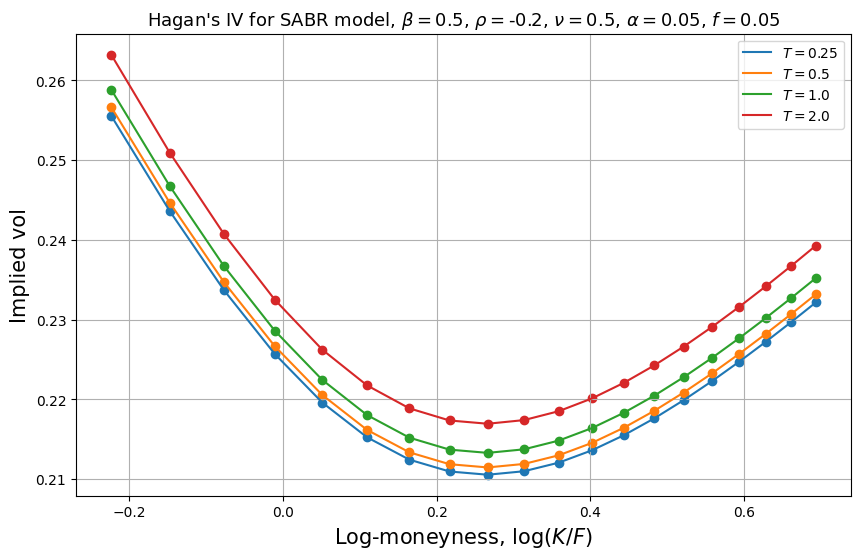

In [24]:
f = 0.05
sabr_params = SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=0.5)
times = np.array([0.25, 0.5, 1, 2])
strikes = np.linspace(0.04, 0.1, 20)
ivs_sabr_approx = np.zeros((times.size, strikes.size))

for i, strike in enumerate(strikes):
    is_call = True if strike > f else False
    ivs_sabr_approx[:, i] = iv_from_approximation(sabr_params=sabr_params, f=f, t=times, k=strike)

plt.figure(figsize=(10, 6))
for i, t in enumerate(times):
    plt.plot(np.log(strikes / f), ivs_sabr_approx[i, :], label="$T={}$".format(t))
    plt.scatter(np.log(strikes / f), ivs_sabr_approx[i, :])

plt.title("Hagan's IV for SABR model, $\\beta=${}, $\\rho=${}, $\\nu=${}, $\\alpha=${}, $f=${}".format(sabr_params.beta, sabr_params.rho, sabr_params.nu, sabr_params.alpha, f), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Log-moneyness, $\log(K/F)$", fontsize=15)
plt.legend()
plt.grid(True)
plt.show(True)

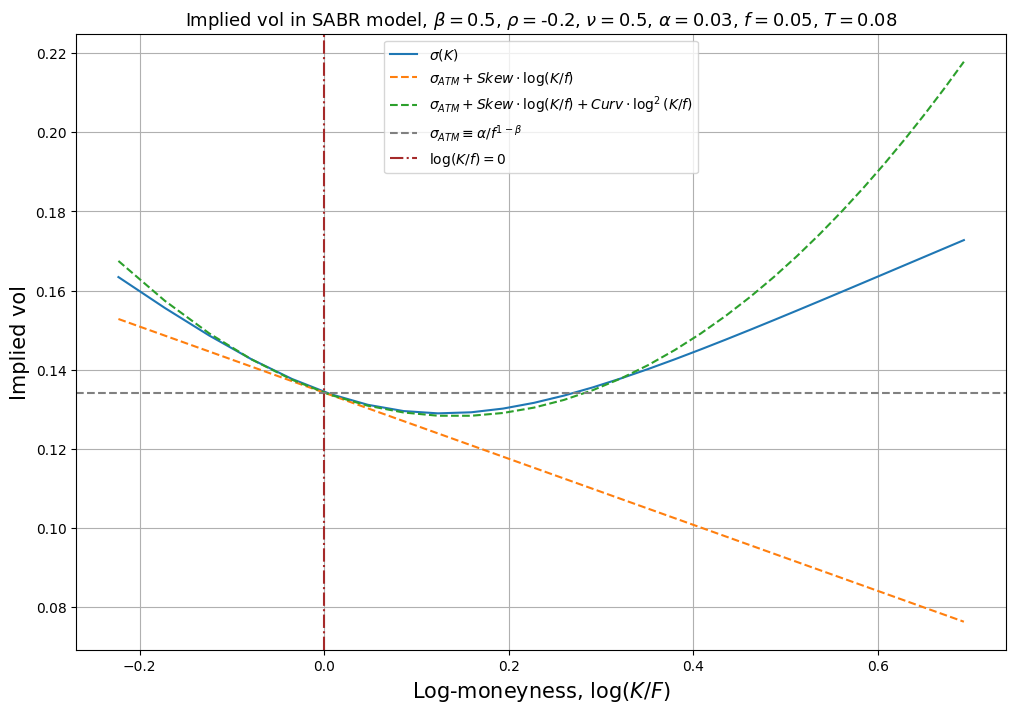

In [25]:
f = 0.05; is_call = True; T = 1/12
sabr_params = SABRparams(alpha=0.03, nu=0.5, rho=-0.2, beta=0.5)

strikes = np.linspace(0.04, 0.1, 30)
ivs_sabr_approx_alphas = np.zeros(strikes.size)


for i, strike in enumerate(strikes):
    is_call = True if strike > f else False
    ivs_sabr_approx_alphas[i] = iv_from_approximation(sabr_params=sabr_params, f=f, t=T, k=strike)

plt.figure(figsize=(12, 8))
plt.plot(np.log(strikes / f), ivs_sabr_approx_alphas[:].flatten(), label="$\\sigma(K)$")

atm = sabr_params.alpha / (f)**(1-sabr_params.beta)
lambda_ = sabr_params.nu * f ** (1 - sabr_params.beta) / sabr_params.alpha
skew = - sabr_params.alpha * (1 - sabr_params.beta - sabr_params.rho * lambda_) / (2 * f ** (1 - sabr_params.beta))
curvature = sabr_params.alpha / (12 * f ** (1 - sabr_params.beta)) * ((1 - sabr_params.beta) ** 2 + (2 - 3 * sabr_params.rho ** 2) * lambda_ ** 2)

plt.plot(np.log(strikes / f), atm + np.log(strikes / f) * skew, linestyle='--', label="$\\sigma_{ATM} + Skew \cdot \log(K/f)$")
plt.plot(np.log(strikes / f), atm + np.log(strikes / f) * skew + np.log(strikes / f) ** 2 * curvature, linestyle='--', label="$\\sigma_{ATM} + Skew \cdot \log(K/f) + Curv \cdot \log^2(K/f)$")
plt.axhline(y=atm, color='grey', linestyle='--', label="$\\sigma_{ATM} \equiv \\alpha / f^{1 - \\beta}$")
plt.axvline(x=0, color='brown', linestyle='-.', label="$\log(K/f)=0$")

plt.title("Implied vol in SABR model, $\\beta=${}, $\\rho=${}, $\\nu=${}, $\\alpha=${}, $f=${}, $T=${}".format(sabr_params.beta, sabr_params.rho, sabr_params.nu, sabr_params.alpha, f, round(T, 2)), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Log-moneyness, $\log(K/F)$", fontsize=15)
plt.legend()
plt.grid(True)
plt.show(True)

#### 1.3 Effects of $\alpha, \beta, \rho, \nu$ on implied vol curve

##### 1.3.1 Initial vol $\alpha$

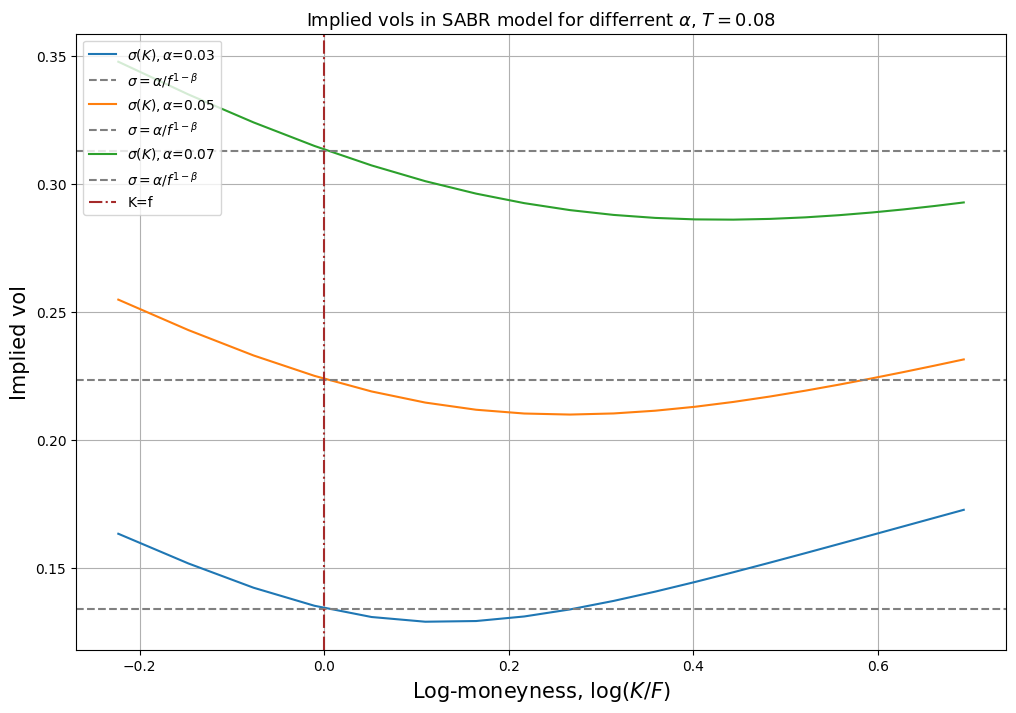

In [26]:
f = 0.05; is_call = True; T = 1/12
sabr_params = [SABRparams(alpha=0.03, nu=0.5, rho=-0.2, beta=0.5),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=0.5),
               SABRparams(alpha=0.07, nu=0.5, rho=-0.2, beta=0.5)]

strikes = np.linspace(0.04, 0.1, 20)
ivs_sabr_approx_alphas = np.zeros((3, strikes.size))

for j, sabr_param in enumerate(sabr_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > f else False
        ivs_sabr_approx_alphas[j, i] = iv_from_approximation(sabr_params=sabr_param, f=f, t=T, k=strike)

plt.figure(figsize=(12, 8))
for j, sabr_param in enumerate(sabr_params):
    plt.plot(np.log(strikes / f), ivs_sabr_approx_alphas[j, :].flatten(), label="$\sigma(K), \\alpha$={}".format(sabr_param.alpha))
    plt.axhline(y=sabr_param.alpha / (f)**(1-sabr_param.beta), color='grey', linestyle='--', label="$\\sigma = \\alpha / f^{1 - \\beta}$")

plt.axvline(x=0, color='brown', linestyle='-.', label="K=f")

plt.title("Implied vols in SABR model for differrent $\\alpha$, $T=${}".format(round(T, 2)), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Log-moneyness, $\log(K/F)$", fontsize=15)
plt.legend()
plt.grid(True)
plt.show(True)

Initial vol $\alpha$ mainly controls the shift the curve, its location. 

##### 1.3.2 Correlation coefficient $\rho$

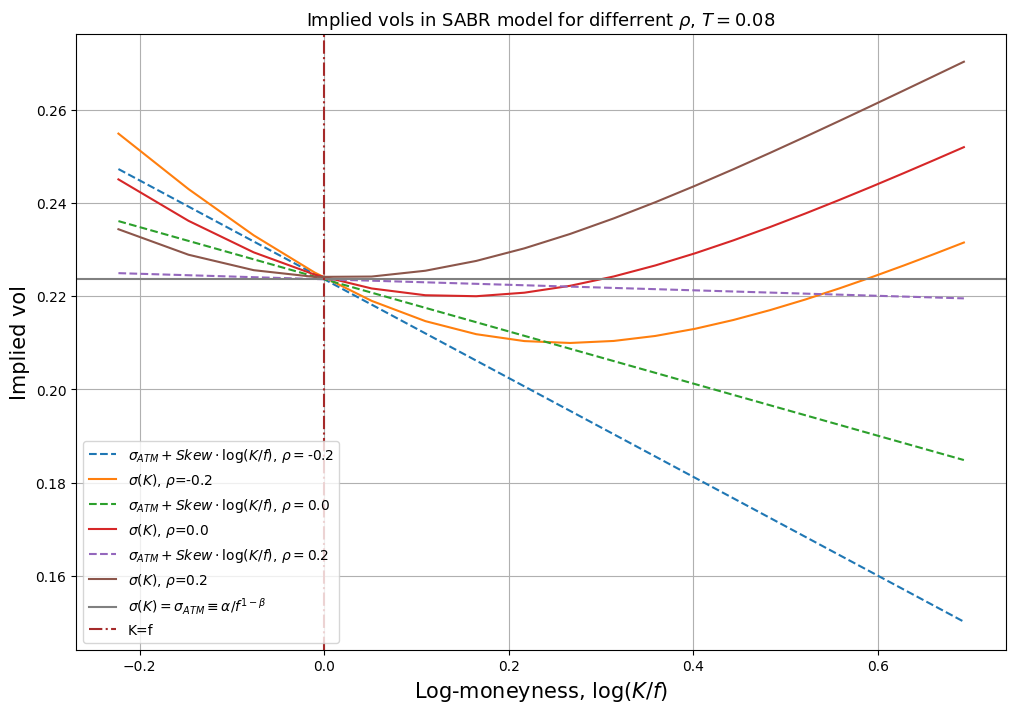

In [27]:
f = 0.05; is_call = True; T=1/12
sabr_params = [SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=0.5),
               SABRparams(alpha=0.05, nu=0.5, rho=0.0, beta=0.5),
               SABRparams(alpha=0.05, nu=0.5, rho=0.2, beta=0.5)]

strikes = np.linspace(0.04, 0.1, 20)
ivs_sabr_approx_alphas = np.zeros((3, strikes.size))

for j, sabr_param in enumerate(sabr_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > f else False
        ivs_sabr_approx_alphas[j, i] = iv_from_approximation(sabr_params=sabr_param, f=f, t=T, k=strike)

plt.figure(figsize=(12, 8))
for j, sabr_param in enumerate(sabr_params):
    atm = sabr_param.alpha / (f) ** (1 - sabr_param.beta)
    lambda_ = sabr_param.nu * f ** (1 - sabr_param.beta) / sabr_param.alpha
    skew = - sabr_param.alpha * (1 - sabr_param.beta - sabr_param.rho * lambda_) / (2 * f ** (1 - sabr_param.beta))
    plt.plot(np.log(strikes / f), atm + np.log(strikes / f) * skew, linestyle='--', label="$\\sigma_{ATM} + Skew \cdot \log(K/f)$, " + "$\\rho=${}".format(sabr_param.rho))
    plt.plot(np.log(strikes / f), ivs_sabr_approx_alphas[j, :].flatten(), label="$\\sigma(K)$, $\\rho$={}".format(sabr_param.rho))

plt.axhline(y=atm, color='grey', linestyle='-', label="$\\sigma(K) = \\sigma_{ATM} \equiv \\alpha / f^{1 - \\beta}$")
plt.axvline(x=0, color='brown', linestyle='-.', label="K=f")
plt.title("Implied vols in SABR model for differrent $\\rho$, $T=${}".format(round(T, 2)), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Log-moneyness, $\log(K/f)$", fontsize=15)
plt.legend()
plt.grid(True)
plt.show(True)

Correlation $\rho$ mainly controls the skew of the curve.

##### 1.3.3 Vol of vol $\nu$

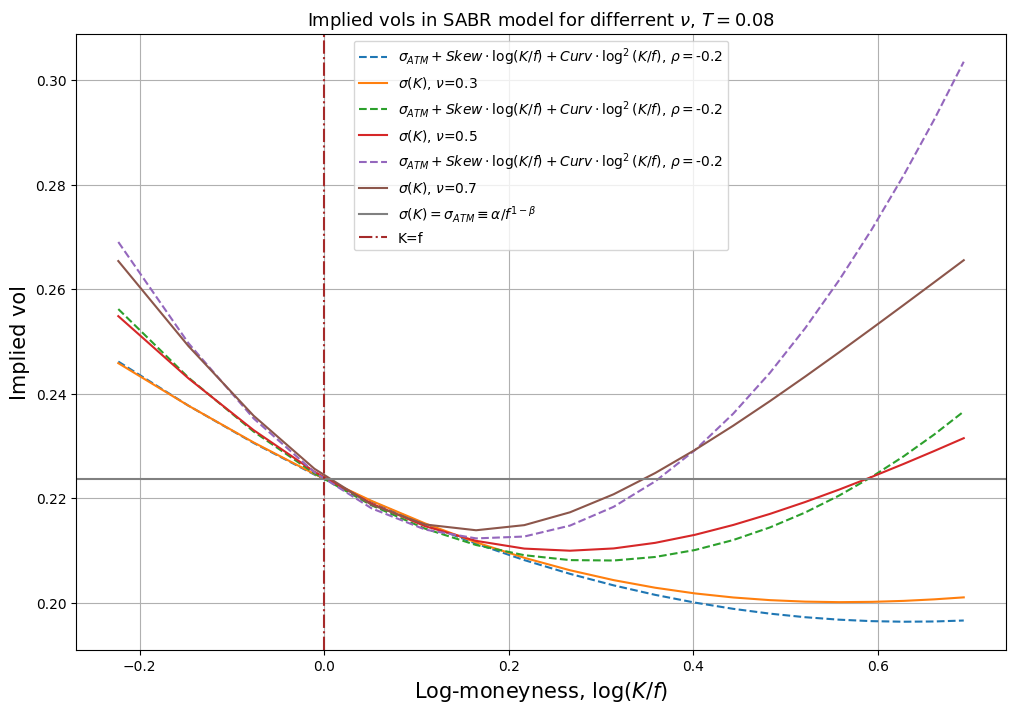

In [28]:
f = 0.05; is_call = True; T=1/12
sabr_params = [SABRparams(alpha=0.05, nu=0.3, rho=-0.2, beta=0.5),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=0.5),
               SABRparams(alpha=0.05, nu=0.7, rho=-0.2, beta=0.5)]

strikes = np.linspace(0.04, 0.1, 20)
ivs_sabr_approx_alphas = np.zeros((3, strikes.size))

for j, sabr_param in enumerate(sabr_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > f else False
        ivs_sabr_approx_alphas[j, i] = iv_from_approximation(sabr_params=sabr_param, f=f, t=T, k=strike)

plt.figure(figsize=(12, 8))
for j, sabr_param in enumerate(sabr_params):
    atm = sabr_param.alpha / (f) ** (1 - sabr_param.beta)
    lambda_ = sabr_param.nu * f ** (1 - sabr_param.beta) / sabr_param.alpha
    skew = - sabr_param.alpha * (1 - sabr_param.beta - sabr_param.rho * lambda_) / (2 * f ** (1 - sabr_param.beta))
    curvature = sabr_param.alpha / (12 * f ** (1 - sabr_param.beta)) * ((1 - sabr_param.beta) ** 2 + (2 - 3 * sabr_param.rho ** 2) * lambda_ ** 2)
    plt.plot(np.log(strikes / f), atm + np.log(strikes / f) * skew + (np.log(strikes / f)) ** 2 * curvature, linestyle='--', label="$\\sigma_{ATM} + Skew \cdot \log(K/f) + Curv \cdot \log^2(K/f)$, " + "$\\rho=${}".format(sabr_param.rho))
    plt.plot(np.log(strikes / f), ivs_sabr_approx_alphas[j, :].flatten(), label="$\\sigma(K)$, $\\nu$={}".format(sabr_param.nu))

plt.axhline(y=atm, color='grey', linestyle='-', label="$\\sigma(K) = \\sigma_{ATM} \equiv \\alpha / f^{1 - \\beta}$")
plt.axvline(x=0, color='brown', linestyle='-.', label="K=f")
plt.title("Implied vols in SABR model for differrent $\\nu$, $T=${}".format(round(T, 2)), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Log-moneyness, $\log(K/f)$", fontsize=15)
plt.legend()
plt.grid(True)
plt.show(True)

Vol of vol $\nu$ mainly controls the convexity of the curve.

##### 1.3.4 Power in local component $\beta$

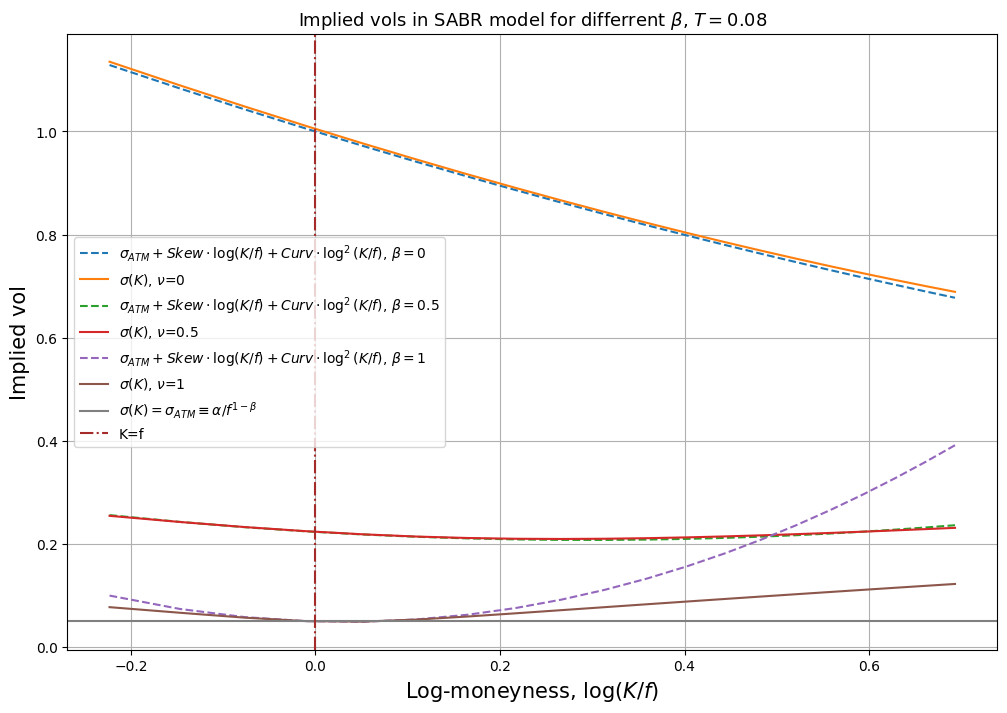

In [29]:
f = 0.05; is_call = True; T=1/12
sabr_params = [SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=0),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=0.5),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.2, beta=1)]

strikes = np.linspace(0.04, 0.1, 20)
ivs_sabr_approx_alphas = np.zeros((3, strikes.size))

for j, sabr_param in enumerate(sabr_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > f else False
        ivs_sabr_approx_alphas[j, i] = iv_from_approximation(sabr_params=sabr_param, f=f, t=T, k=strike)

plt.figure(figsize=(12, 8))
for j, sabr_param in enumerate(sabr_params):
    atm = sabr_param.alpha / (f) ** (1 - sabr_param.beta)
    lambda_ = sabr_param.nu * f ** (1 - sabr_param.beta) / sabr_param.alpha
    skew = - sabr_param.alpha * (1 - sabr_param.beta - sabr_param.rho * lambda_) / (2 * f ** (1 - sabr_param.beta))
    curvature = sabr_param.alpha / (12 * f ** (1 - sabr_param.beta)) * ((1 - sabr_param.beta) ** 2 + (2 - 3 * sabr_param.rho ** 2) * lambda_ ** 2)
    plt.plot(np.log(strikes / f), atm + np.log(strikes / f) * skew + (np.log(strikes / f)) ** 2 * curvature, linestyle='--', label="$\\sigma_{ATM} + Skew \cdot \log(K/f) + Curv \cdot \log^2(K/f)$, " + "$\\beta=${}".format(sabr_param.beta))
    plt.plot(np.log(strikes / f), ivs_sabr_approx_alphas[j, :].flatten(), label="$\\sigma(K)$, $\\nu$={}".format(sabr_param.beta))

plt.axhline(y=atm, color='grey', linestyle='-', label="$\\sigma(K) = \\sigma_{ATM} \equiv \\alpha / f^{1 - \\beta}$")
plt.axvline(x=0, color='brown', linestyle='-.', label="K=f")
plt.title("Implied vols in SABR model for differrent $\\beta$, $T=${}".format(round(T, 2)), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Log-moneyness, $\log(K/f)$", fontsize=15)
plt.legend()
plt.grid(True)
plt.show(True)

We see that $\beta$ gives the same effect as $\rho$. So why do wee need it? In fact, we can calibrate $\beta$ to an implied volatility response! 

#### 1.4 IV response

In [30]:
f = 0.05; is_call = True; T=1/12
sabr_params = [SABRparams(alpha=0.05, nu=0.5, rho=-0.9, beta=1),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.9, beta=0.5),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.9, beta=0.25),
               SABRparams(alpha=0.05, nu=0.5, rho=-0.9, beta=0)]

strikes_size = 13
strikes = np.linspace(0.02, 0.08, strikes_size)
ivs_sabr_approx_alphas = np.zeros((3, 4, strikes.size))
f_moves = [f - f * 0.1, f, f + f * 0.1]

for j, sabr_param in enumerate(sabr_params):
    for i, strike in enumerate(strikes):
        is_call = True if strike > f else False
        for k, f_move in enumerate(f_moves):
            ivs_sabr_approx_alphas[k, j, i] = iv_from_approximation(sabr_params=sabr_param, f=f_move, t=t, k=strike)

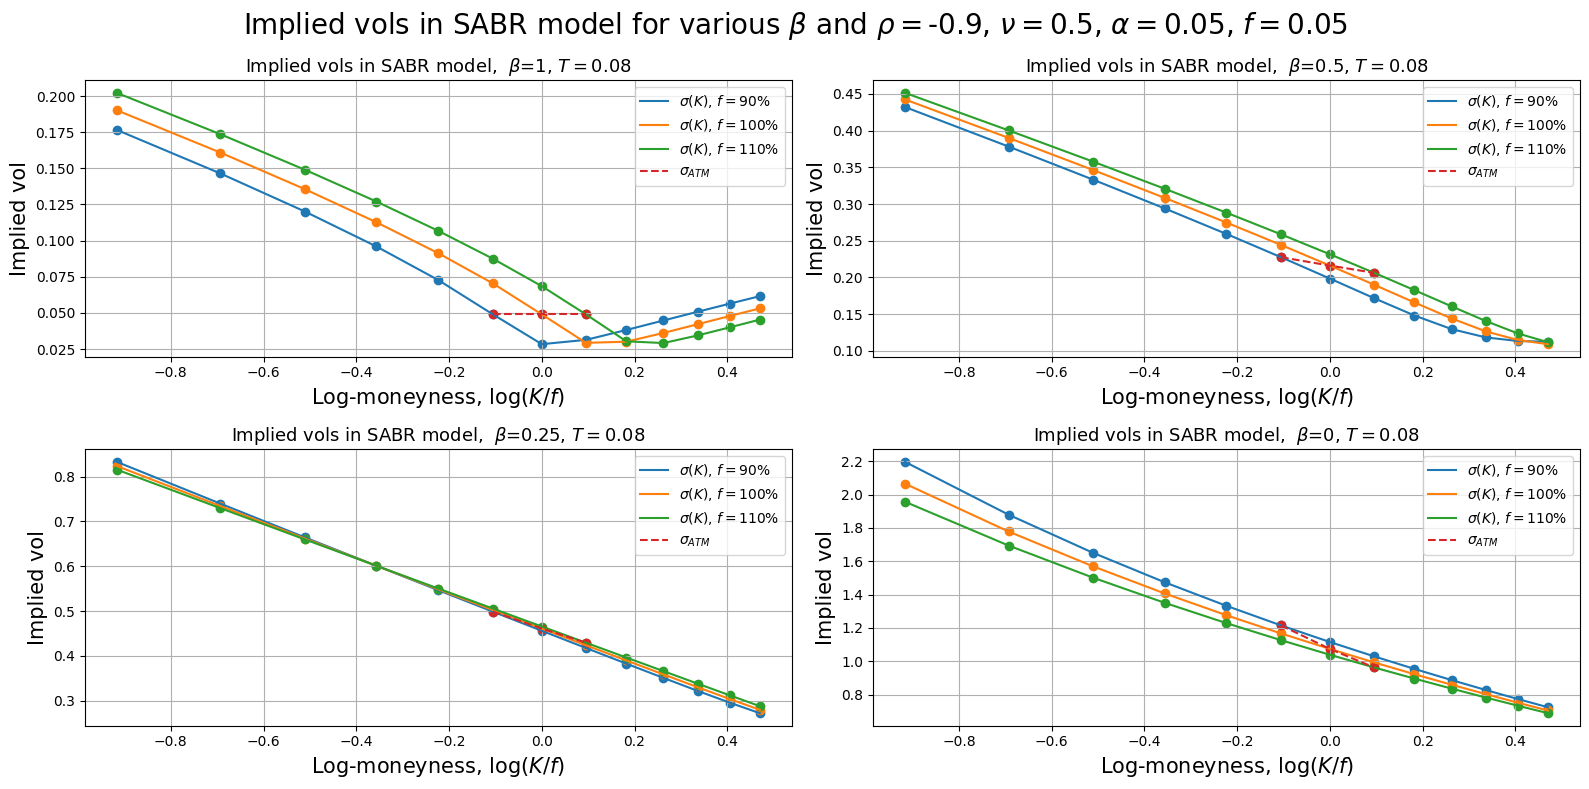

In [31]:
    
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Implied vols in SABR model for various $\\beta$ and $\\rho=${}, $\\nu=${}, $\\alpha=${}, $f=${}".format(sabr_params[0].rho, sabr_params[0].nu, sabr_params[0].alpha, f), fontsize=20)

for i in range(2):
    for j in range(2):
        ind = i * 2 + j
        ivs_atm = []
        for k, f_ in enumerate(f_moves):
            axs[i][j].plot(np.log(strikes / f), ivs_sabr_approx_alphas[k, ind, :], label="$\\sigma(K)$, $f=${}%".format(round(f_ * 100 / f)))
            ivs_atm.append(ivs_sabr_approx_alphas[k, ind, strikes_size // 2 - 1 + k])
            axs[i][j].scatter(np.log(strikes / f), ivs_sabr_approx_alphas[k, ind, :])
        axs[i][j].plot(np.log(strikes[strikes_size // 2 - 1 : strikes_size // 2 + 2] / f), ivs_atm, linestyle="--", label="$\sigma_{ATM}$")
        axs[i][j].scatter(np.log(strikes[strikes_size // 2 - 1 : strikes_size // 2 + 2] / f), ivs_atm)
        axs[i][j].set_title("Implied vols in SABR model,  $\\beta$={}, $T=${}".format(sabr_params[ind].beta, round(T, 2)), fontsize=13)
        axs[i][j].set_ylabel("Implied vol", fontsize=15)
        axs[i][j].set_xlabel("Log-moneyness, $\log(K/f)$", fontsize=15)
        axs[i][j].legend()
        axs[i][j].grid(True)

fig.tight_layout()
        

With given parameters $\alpha=0.05$, $\nu=0.5$ and $\rho=-0.9$:

* When $\beta = 1$ we get sticky delta dynamics, i.e. if spot changes, the implied volatility of an option with a given moneyness (delta) does not change.

* When $\beta = 0.5$ we get something between sticky strike and sticky delta dynamics. 

* When $\beta = 0.25$ we get sticky strike dynamics, i.e. if spot changes, the implied volatility of an option with a given absolute strike does not change.

* When $\beta = 0$ we get sticky local vol dynamics, i.e. if spot changes, the implied volatility shifts in an opposite direction.

#### 1.5 Calibration

In [32]:
def objective(p, t, k, f, iv, calibrate_beta, beta0):
    ivs = np.zeros((t.size, k.size))
    for i, strike in enumerate(k):
        sabr_params = SABRparams(*p) if calibrate_beta else SABRparams(*p, beta=beta0)
        ivs[:, i] = iv_from_approximation(sabr_params=sabr_params, f=f, t=t, k=strike)

    return np.linalg.norm(ivs - iv)

In [33]:
def calibrate(t: Union[float, np.ndarray],
              k: np.ndarray,
              iv: np.ndarray,
              f: float,
              min_method: str = "L-BFGS-B",
              beta0: float = 0.8,
              calibrate_beta: bool = True):
        """Calibrates the parameters of the SABR model.

        This function finds the parameters `alpha`, `beta`, `rho`, `nu` of the
        model which minimize the sum of squares of the differences between
        market and model implied volatilities. Returns an instance of the class
        with the calibrated parameters.

        Args:
            t : Expiration time (scalar or array).
            k: Array of strikes.
            iv: Array of market implied volatilities.
            f: Initial forward price.
            min_method: Minimization method to be used, as accepted by
                `scipy.optimize.minimize`. The method must be able to handle
                bounds.
            beta0: Initial guess of parameter `beta` (see notes below).
        """
        alpha0 = iv[np.abs(k - f).argmin()]  # ATM volatility

        k_ = k.flatten()
        iv_ = iv.flatten()
        if isinstance(t, float):
            t_ = np.ones_like(k_) * t
        else:
            t_ = t.flatten()

        if calibrate_beta:
            res = opt.minimize(
                fun=objective,
                x0=(alpha0, 1, 0, beta0),  # (alpha, nu, rho, beta)
                method=min_method,
                args=(t_, k_, f, iv, calibrate_beta, beta0),
                bounds=[(0, np.inf), (0, np.inf), (-1, 1), (0, np.Inf)])

        else:
            res = opt.minimize(
                fun=objective,
                x0=(alpha0, 1, 0),  # (alpha, nu, rho)
                method=min_method,
                args=(t_, k_, f, iv, calibrate_beta, beta0),
                bounds=[(0, np.inf), (0, np.inf), (-1, 1)])

        return res

In [34]:
strikes_data, call_price_data = np.loadtxt("data/data.txt", skiprows=1, delimiter=",", unpack=True)

In [35]:
s = 1.0; t = 0.25; r = 0; q = 0; f = s * np.exp(r * t)
implied_vol_data = np.zeros(strikes_data.size)

price_data = call_price_data
is_call = strikes_data > s
price_data[~is_call] = call_price_data[~is_call] + strikes_data[~is_call] * np.exp(-r * t) - s * np.exp(-q * t)

for i, strike in enumerate(strikes_data):
    implied_vol_data[i] = iv_black_scholes(price=price_data[i], S=s, K=strike, t=t, r=r, is_call=is_call[i])

In [36]:
res = calibrate(t, strikes_data, implied_vol_data, f, calibrate_beta=True)

AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

In [303]:
res.x

array([0.42378084, 0.3660824 , 0.71236468, 0.        ])

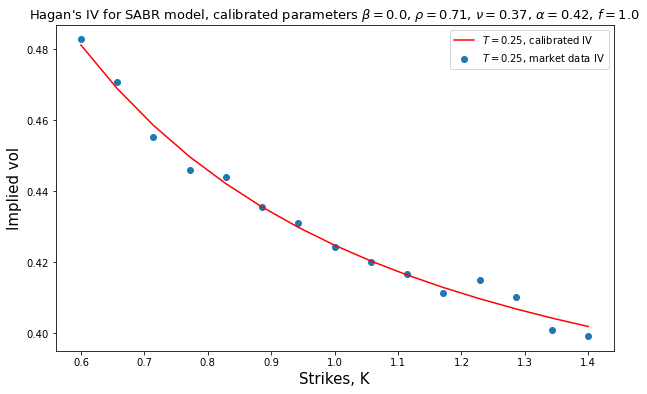

In [304]:
sabr_params = SABRparams(*res.x)
times = 0.25
strikes = strikes_data
ivs_sabr_approx = np.zeros((1, strikes.size))

for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    ivs_sabr_approx[:, i] = iv_from_approximation(sabr_params=sabr_params, f=f, t=times, k=strike)

plt.figure(figsize=(10, 6))
plt.plot(strikes, ivs_sabr_approx[0, :], label="$T={}$, calibrated IV".format(t), color="red")
plt.scatter(strikes, implied_vol_data, label="$T={}$, market data IV".format(t))


plt.title("Hagan's IV for SABR model, calibrated parameters $\\beta=${}, $\\rho=${}, $\\nu=${}, $\\alpha=${}, $f=${}".format(round(sabr_params.beta, 2), 
                                                                                                       round(sabr_params.rho, 2), 
                                                                                                       round(sabr_params.nu, 2),
                                                                                                       round(sabr_params.alpha, 2),
                                                                                                       f), fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

Can we obtain the same IV curve without calibration of $\beta$?

In [306]:
res1 = calibrate(t, strikes_data, implied_vol_data, f, calibrate_beta=False, beta0=0)
res2 = calibrate(t, strikes_data, implied_vol_data, f, calibrate_beta=False, beta0=1)

In [307]:
res1.x, res2.x

(array([0.42378092, 0.36608022, 0.71236869]),
 array([ 0.42560635,  0.42659163, -0.41055778]))

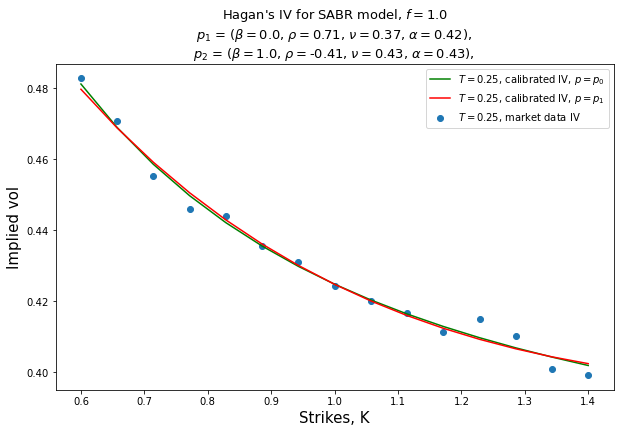

In [308]:
sabr_params_beta0 = SABRparams(*res1.x, 0.0)
sabr_params_beta1 = SABRparams(*res2.x, 1.0)

times = 0.25
strikes = strikes_data
ivs_sabr_approx = np.zeros((2, 1, strikes.size))

for i, strike in enumerate(strikes):
    is_call = True if strike > s else False
    ivs_sabr_approx[0, :, i] = iv_from_approximation(sabr_params=sabr_params_beta0, f=f, t=times, k=strike)
    ivs_sabr_approx[1, :, i] = iv_from_approximation(sabr_params=sabr_params_beta1, f=f, t=times, k=strike)

plt.figure(figsize=(10, 6))
plt.plot(strikes, ivs_sabr_approx[0, 0, :], label="$T={}$, calibrated IV, $p=p_0$".format(t), color="green")
plt.plot(strikes, ivs_sabr_approx[1, 0, :], label="$T={}$, calibrated IV, $p=p_1$".format(t), color="red")
plt.scatter(strikes, implied_vol_data, label="$T={}$, market data IV".format(t))


plt.title("Hagan's IV for SABR model, $f=${}".format(f) + 
          "\n" + 
          "$p_1$ = ($\\beta=${}, $\\rho=${}, $\\nu=${}, $\\alpha=${}), ".format(round(sabr_params_beta0.beta, 2), 
                                                                                round(sabr_params_beta0.rho, 2), 
                                                                                round(sabr_params_beta0.nu, 2),
                                                                                round(sabr_params_beta0.alpha, 2)) + 
          "\n" + 
          "$p_2$ = ($\\beta=${}, $\\rho=${}, $\\nu=${}, $\\alpha=${}), ".format(round(sabr_params_beta1.beta, 2), 
                                                                                round(sabr_params_beta1.rho, 2), 
                                                                                round(sabr_params_beta1.nu, 2),
                                                                                round(sabr_params_beta1.alpha, 2)), 
            fontsize=13)
plt.ylabel("Implied vol", fontsize=15)
plt.xlabel("Strikes, K", fontsize=15)
plt.legend()
plt.show(True)

#### 1.5 References

1. Hagan, Kumar, Lesniewski, Woodward, **“Managing smile risk”**, 2002.
